# 1 period, 1 firm case

This notebook works through a simple test case where we have one firm, optimizing over one period (no future after this period). 

Firms will aim to generate as much as possible, resulting in an exogenously given generation target $G$. 

Under the $\mathbb{P}$ measure, they will generate $G(2p\epsilon + (1-p))$, where $\epsilon \sim U(0,1)$. Consequently, it is clear that $2p\epsilon + (1-p) \sim U(1-p, 1+p)$. $p$ is an exogenously given parameter that is chosen to accurately model generation uncertainty.

Under the $\mathbb{Q}$ (risk neutral) measure, $\epsilon \sim $ Beta$(a, b)$. We note that the two measures are absolutely continuous with respect to one another as they have the same support of $(0,1)$.

Note: This may not be the best choice of generation randomness. Would potential reviewers have an issue with this? 

Some other definitions (all exogeneously provided):

$R$ - the requirement imposed by the regulatory body on clean energy generation

$\pi$ - the penalty per unit of non-compliance

$C(G)$ - the cost of planned generation in the amount $G$.


In this setup, our control is $\Gamma$, the amount of certificates that we buy. In the 1-period case, we do not have any state variables. This will change when we extend to multiple periods and introduce the notion of banking.

For now, we impose that $\Gamma > - G(1-p)$ - essentially, this means that we cannot ever end up short in certificates.

In our control setup for this simple case, a firm chooses $\Gamma$ such that they minimize the cost function below:

$ C = \min_{\Gamma}\{ C(G) + \pi E^\mathbb{P}[(R - (G(2p\epsilon + (1-p)) + \Gamma)_+)_+] - \pi E^\mathbb{Q}[(R - (G(2p\epsilon + (1-p))))_+ -(R - (G(2p\epsilon + (1-p)) + \Gamma)_+)_+]$

The first term is the cost of generation, the second term is the cost of non-compliance, and the third term is an indifference pricing argument for the cost of the trades made (have to pay the value of having $\Gamma$ certificates, under the $\mathbb{Q}$ measure). 

Note: the reason the MC definition of price doesn't work is that it doesn't account for the fact that after a certain number of certificates, they no longer hold value to you (except for possibly the ability to bank them, which we can capture by updating the state variables when appropriate -- of course, this only applies to multiperiod models). Also, I don't quite understand the usage of FTAP when the asset value at time T is dependent on who is holding it


Through some annoying analysis, we obtain:

$E^\mathbb{P}[(R - (G(2p\epsilon + (1-p)) + \Gamma)_+)_+] = R E - G p (E^2 - D^2) - (\Gamma + G(1-p))(E - D)$

$E^\mathbb{Q}[(R - (G(2p\epsilon + (1-p))))_+] = (R - G(1-p)) \int_{0}^{A}f(x)dx - 2Gp \int_{0}^{A} g(x) dx$

$E^\mathbb{Q}[(R - (G(2p\epsilon + (1-p)) + \Gamma)_+)_+] = R \int_{0}^{E} f(x) dx - (\Gamma + G (1-p))\int_{D}^{E} f(x)dx - 2Gp\int_{D}^{E} g(x)dx$

where $E = \min(1, \frac{R - G(1-p) - \Gamma}{2Gp}), D = \max(0, \frac{-\Gamma - G(1-p)}{2Gp}), A = \min(1, \frac{R - G(1-p)}{2Gp}), f(x) = \frac{x^{a-1}(1-x)^{b-1}}{B(a,b)}, g(x) = \frac{x^{a}(1-x)^{b-1}}{B(a,b)}$

I will provide full derivations if requested, but I am reasonably confident that the above is correct.

We will now go through a quick exercise in plotting and minimizing this, for some arbitrarily chosen values

28110.983499
28550.0


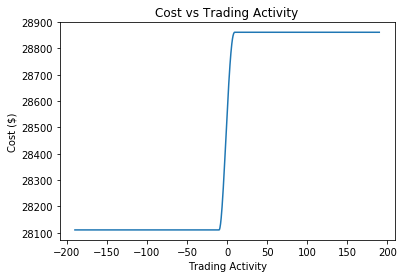

In [2]:
import numpy as np
from scipy.stats import beta
from scipy.special import beta as bt
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# simple code for the 1 period, 1 firm case
# firms will aim to generate as much as possible, resulting in an exogeneous generation target G
# Under the P-measure, they will generate G(2p \epsilon)

# somewhat randomly chosen values for the time being
R = 200
G = 200
pi = 300 # SACP of 300 is in line with the NJ SREC market in 2019
p = 0.05

# beta distribution parameters - again chosen somewhat randomly
# not sure how to choose these in a more intelligent way
a = 1.2
b = 2



def costs(gamma, gen):
    D = min(max(0, (- gamma - gen * (1 - p)) / (2. * gen * p)),1)
    E = max(min(1, (R - gen * (1 - p) - gamma) / (2. * gen * p)),0)
    A = max(min(1, (R - gen * (1 - p)) / (2 * gen * p)),0)
    g_1 = integrate.quad(lambda x: ((x ** a) * (1 - x) ** (b-1))/(bt(a,b)), 0, A)[0]
    g_2 = integrate.quad(lambda x: ((x ** a) * (1 - x) ** (b-1))/(bt(a,b)), D, E)[0]



    def prodcost(gg):  # linear costs, another assumption
        # using the costs from https://www.lazard.com/media/450337/lazard-levelized-cost-of-energy-version-110.pdf
        # assuming midpoint of range for Solar PV - Rooftop commercial & industrial (139/MWh)
        # would change depending on the producer, but this is a reasonable LCOE
        fixed_cost = 0  # fixed costs do exist, but dont really impact our decision making, as we would incur them anyways
        return fixed_cost + 139. * gg

    def noncompliancecost(gamma):
        return R * E - gen * p * (E**2 - D ** 2) - (gamma + gen*(1-p))*(E - D)

    def tradingcost():
        hold_zero = (R - gen * (1 - p)) * beta.cdf(A, a, b) - 2. * gen * p * g_1 # fix this
        hold_gamma = R * beta.cdf(E, a, b) - (gamma + gen* (1-p)) * (beta.cdf(E, a, b) - beta.cdf(D, a, b)) - \
                     2 * gen * p * g_2

        return hold_zero - hold_gamma
    # print("Cost of generation: " + str(prodcost(gen)))
    # print("Cost of non-compliance: " + str(pi * (noncompliancecost(gamma))))
    # print("Cost of trading: " + str(pi * (tradingcost())))

    return prodcost(gen) + pi * (noncompliancecost(gamma) + tradingcost())


gammas = np.linspace(-G * (1-p), G*(1-p), 1000)
Gs = [G]*1000
cost_list = list(map(costs, gammas, Gs))
#print(cost_list)
plt.plot(gammas, cost_list)
plt.xlabel("Trading Activity")
plt.ylabel("Cost ($)")
plt.title("Cost vs Trading Activity")
plt.show()

This is non-convex. We can see that there are many minimums... this may change when multiple periods are incorporated, as one would be disincentivized to sell so many certificates. 